# Preparation and Classification of EMNIST ByClass and ByMerge Datasets
---
<b>This notebook is split in two parts:</b>

    1. Preperation of the EMNIST (Extended Modified NIST) dataset for use in the second part.
    
    2. Modeling of various machine learning methods for classifying the 62 unevenly distributed classes in this dataset. The prediction performance of the models considered in this notebook serves as a benchmark to determine the discrepancy in performance after the datasets are reduced in subsequent notebooks and the models are retrained on the reduced data.
---

<b>Classification task and information about the EMNIST Dataset:</b>

According to the description in <a href=#1>[1]</a>, the original NIST dataset serves five different classification tasks, also called data hierarchy, of which we focus on the $By\_Class$ and $By\_Merge$ categories, which are about classifying handwritten digits and letters:

The $By\_Class$ variant is concerned with classifying the 62 different classes, which consist of the numbers [0-9] and the letters [a-z] or [A-Z].

The $By\_Merge$ variant merges letters that cause ambiguity in the classification. Here, 14 letters in lowercase and uppercase are combined, since they are often confused with each other and are difficult to distinguish even for the human eye.

The datasets consist of <i>814255</i> samples out of which <i>697932</i> are for training and the remaining <i>116323</i> are for testing. Almost half of the data consists of numbers, while the remaining categories, mainly letters, are typically heavily underrepresented and unbalanced. More information about the remaining tasks in the hierarchy, how the data conversion took place and what strategy was used to split the data can be read in <a href=#1>[1]</a>.

Figure 2 in <a href=#1>[1]</a> illustrates the class distributions of both datasets and those classes in the $By\_Merge$ dataset that were merged (shown with vertical arrows):

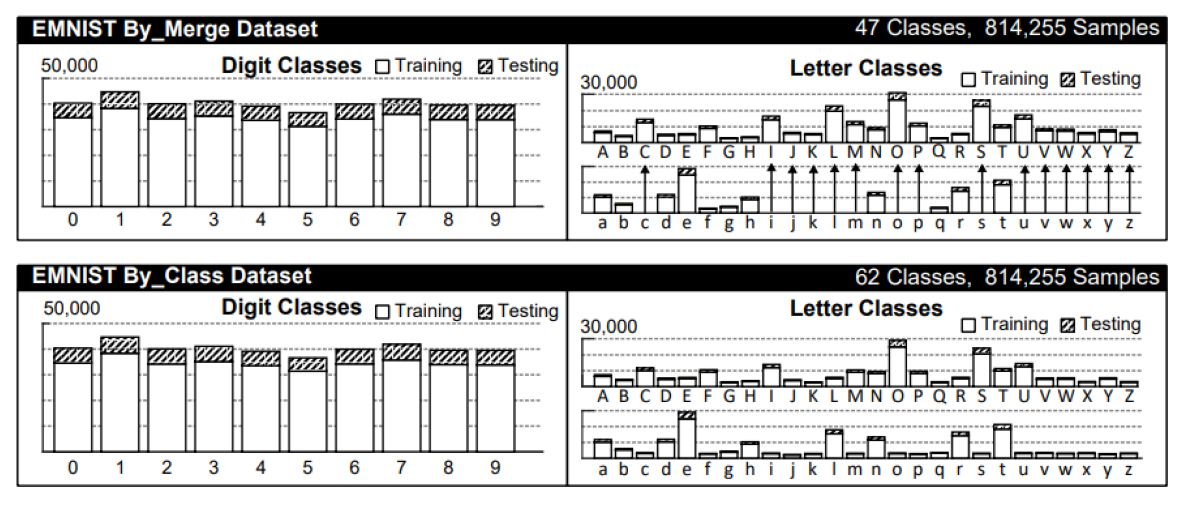

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15, 12))
img = mpimg.imread('./images/ByMerge_ByClass_Distributions.png')
plt.imshow(img)
plt.axis("off")
plt.show()

---

In [2]:
import os
import time
import sys
import psutil
import GPUtil
import cpuinfo
import platform
from tqdm import tqdm

# standard data manipulation libs --------------------------------------
import numpy as np
import pandas as pd
np.random.seed(42)

# data visualization libs ----------------------------------------------
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

#beautification of plots
pio.templates.default = "simple_white"

px.defaults.template = "plotly_white"
px.defaults.color_continuous_scale = px.colors.sequential.Blackbody
px.defaults.width = 1200
px.defaults.height = 750

# scikit-learn base transformers ----------------------------------------
from sklearn.base import BaseEstimator, TransformerMixin

# sckit-learn preprocessing methods -------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# scikit-learn cross validation methods ---------------------------------
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# scikit-learn classication evaluation metrics --------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# scikit-learn splitting techniques -------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold 

# scikit-learn clustering methods ---------------------------------------
from sklearn.cluster import KMeans

# scikit-learn classifiers ----------------------------------------------
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# ignoring future warnings for better notebook readability --------------
from warnings import simplefilter 
simplefilter('ignore', FutureWarning)

# Hardware Specification and OS
You will see it is a quite powerful machine, located at the <i><a href="https://www.bigdata.fh-aachen.de/"> BigData-Lab at FH Aachen</a></i>. We call this machine <b>Phobos</b>.

OS Specification

In [3]:
print(f"OS: {platform.system()}")
print(f"Release: {platform.release()}")
print(f"Version: {platform.version()}")

OS: Windows
Release: 10
Version: 10.0.22631


<i>CPU Specification</i>

In [4]:
print(f'CPU Model: {cpuinfo.get_cpu_info()["brand_raw"]}')
print(f'Physical Cores: {psutil.cpu_count(logical=False)}')
print(f'Logical Cores: {psutil.cpu_count(logical=True)}')
print(f'Max. Freq.: {int(psutil.cpu_freq().max)} MHz')

CPU Model: Intel(R) Xeon(R) w5-3435X
Physical Cores: 16
Logical Cores: 32
Max. Freq.: 3096 MHz


Memory Specification


In [6]:
ram_capacity_gb = psutil.virtual_memory().total / (1024**3)
print(f"RAM: {ram_capacity_gb:.2f} GB")
hdd_capacity_gb = psutil.disk_usage('/').total / (1024**3)
print(f"HDD: {hdd_capacity_gb:.2f} GB")

RAM: 511.00 GB
HDD: 10870.95 GB


<i>GPU Specification</i>

In [7]:
gpu = GPUtil.getGPUs()[0]
print(f'GPU Model: {gpu.name} {np.round(gpu.memoryTotal / 1024, 1)} GB')

GPU Model: NVIDIA RTX A6000 48.0 GB


---

# **Part I: Preparation of EMNIST ByClass and ByMerge**

---

# 1 Read the datasets

The version of the EMNIST dataset used here is already unpacked as a training and test set (splits provided by maintainers) in the **/Datasets** directory and can be loaded immediately. 

For the full version, including the entire data hierarchy in a zip file, refer to the original [NIST](https://www.nist.gov/itl/products-and-services/emnist-dataset) webpage or see on [kaggle](https://www.kaggle.com/datasets/crawford/emnist) where the data is provided in csv format.

In [8]:
from src.utils.datasets import fetch_dataset

%time bC_train = pd.read_parquet(**fetch_dataset("emnist-byclass-train", "raw"))
bC_test = pd.read_parquet(**fetch_dataset("emnist-byclass-test", "raw"))

%time bM_train = pd.read_parquet(**fetch_dataset("emnist-bymerge-train", "raw"))
bM_test = pd.read_parquet(**fetch_dataset("emnist-bymerge-test", "raw")) 

CPU times: total: 16.5 s
Wall time: 29.9 s
CPU times: total: 13.9 s
Wall time: 27.5 s


# 1.1 Extract Labels and Features

We split the training and test data into features and labels. The first column in each training dataset refers to the class.

In [9]:
from collections import defaultdict
emnist = defaultdict(lambda: defaultdict(pd.DataFrame))

emnist["ByClass"]["X_train"] = bC_train.drop(["0"], axis=1) # first column refers to the class labels
emnist["ByClass"]["y_train"] = bC_train["0"]
emnist["ByClass"]["X_test"] = bC_test.drop(["0"], axis=1)
emnist["ByClass"]["y_test"] = bC_test["0"]

emnist["ByMerge"]["X_train"] = bM_train.drop(["0"], axis=1) # first column refers to the class labels
emnist["ByMerge"]["y_train"] = bM_train["0"]
emnist["ByMerge"]["X_test"] = bM_test.drop(["0"], axis=1)
emnist["ByMerge"]["y_test"] = bM_test["0"]

In [10]:
emnist["ByMerge"]["X_train"].columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '775', '776', '777', '778', '779', '780', '781', '782', '783', '784'],
      dtype='object', length=784)

In [11]:
emnist["ByClass"]["X_train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697932 entries, 0 to 697931
Columns: 784 entries, 1 to 784
dtypes: int64(784)
memory usage: 4.1 GB


In [12]:
emnist["ByMerge"]["X_train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697932 entries, 0 to 697931
Columns: 784 entries, 1 to 784
dtypes: int64(784)
memory usage: 4.1 GB


# 1.2 Get a Map of Categories

A mapping sequence is needed which maps the label indices to their actual labels. 

In [13]:
np.unique(emnist["ByClass"]["y_train"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [14]:
np.unique(emnist["ByMerge"]["y_train"])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=int64)

In [15]:
from src.utils.datasets import get_map

byClass_map = dict(pd.read_csv(**get_map("emnist-byclass")).values)
byMerge_map = dict(pd.read_csv(**get_map("emnist-bymerge")).values)

def bC_map(data):
    if isinstance(data, pd.Series):
        return data.apply(lambda c: chr(byClass_map[c]))
    else: 
        return chr(byClass_map[data])

def bM_map(data):
    if isinstance(data, pd.Series): 
        return data.apply(lambda c: chr(byMerge_map[c]))
    else:
        return chr(byMerge_map[data])

File downloaded to: C:\Users\baran\AppData\Local\Temp\tmpy6cwlt4_
File downloaded to: C:\Users\baran\AppData\Local\Temp\tmpuvbr6r4i


In [84]:
# import string

# def MapToCategory():
#     '''maps emnist (byClass) label indices to their actual labels'''
#     digits = np.arange(0, 10)
#     lower_case = np.array(list(string.ascii_lowercase))
#     upper_case = np.array(list(string.ascii_uppercase))

#     all_classes = np.hstack((digits, upper_case, lower_case))

#     cat_map = dict()
#     for entry, _class in enumerate(all_classes):
#         cat_map[entry] = _class
    
#     return cat_map
    
# bC_map = MapToCategory()
# print(bC_map)

In [85]:
# byclass_map = pd.read_table("./Datasets/raw/emnist/emnist-byclass-mapping.txt", header=None, sep=" ")
# byclass_map

We then can apply it to the labels like follows:

In [18]:
bC_map(emnist["ByClass"]["y_train"][:5])

0    Z
1    a
2    6
3    3
4    M
Name: 0, dtype: object

Let's visualize some random sample in each of the datasets. Here we will see that the images are not positioned properly.

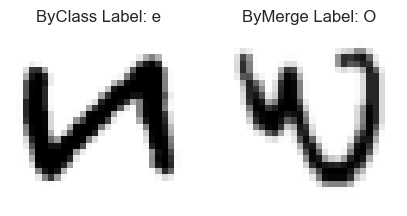

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

ax[0].imshow(emnist["ByClass"]["X_train"].iloc[0].to_numpy().reshape(28, 28), cmap="binary")
ax[0].set_title(f"ByClass Label: {bC_map(emnist['ByClass']['y_train'][120])}")
ax[1].imshow(emnist["ByMerge"]["X_train"].iloc[12].to_numpy().reshape(28, 28), cmap="binary")
ax[1].set_title(f"ByMerge Label: {bM_map(emnist['ByMerge']['y_train'][120])}")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# 1.3 Center the Data

The images are rotated by 90 degrees and flipped left right. The following function corrects this.

In [20]:
def center_input_data(X):
    '''performs a left-right flip and 90° rotation of the tensors'''
    X_centered = np.empty_like(prototype=X)
    
    for i, x_i in enumerate(X.values):
        X_centered[i] = np.rot90(np.fliplr(x_i.reshape(28, 28))).ravel()
        
    return X_centered

In [21]:
%%time
emnist["ByClass"]["X_train"] = center_input_data(emnist["ByClass"]["X_train"])
emnist["ByClass"]["X_test"] = center_input_data(emnist["ByClass"]["X_test"])

emnist["ByMerge"]["X_train"] = center_input_data(emnist["ByMerge"]["X_train"])
emnist["ByMerge"]["X_test"] = center_input_data(emnist["ByMerge"]["X_test"])

CPU times: total: 12.1 s
Wall time: 19.3 s


# 1.4 Some Example Images

After we processed the dataset such that we can use them for modelling, we can now take a look at some example images aranged in a grid.

In [22]:
def show_input_data(data, map, rows=5, cols=5):
    X_train, y_train = data
    fig, ax = plt.subplots(rows, cols, subplot_kw=dict(xticks=[], yticks=[]), figsize=(6,5))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=1.6, 
                        hspace=0.4)
    for i, axi in enumerate(ax.flat):
        axi.imshow(X_train[i].reshape(28, 28), cmap="gray_r")
        axi.set_title(map(y_train[i]), fontsize=24)

ByClass example images:



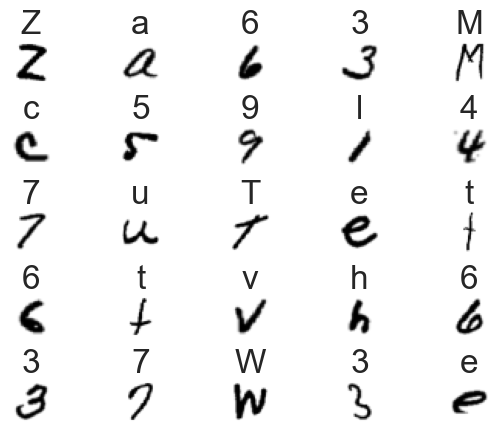

In [23]:
print("ByClass example images:\n")
show_input_data(data=(emnist["ByClass"]["X_train"], emnist["ByClass"]["y_train"]), map=bC_map)

ByMerge example images:



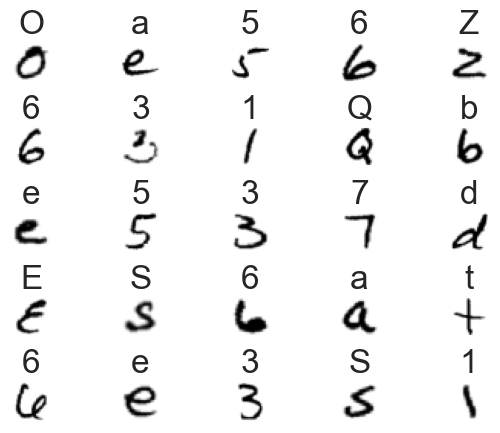

In [24]:
print("ByMerge example images:\n")
show_input_data(data=(emnist["ByMerge"]["X_train"], emnist["ByMerge"]["y_train"]), map=bM_map)

# 1.5 Distribution of Categories

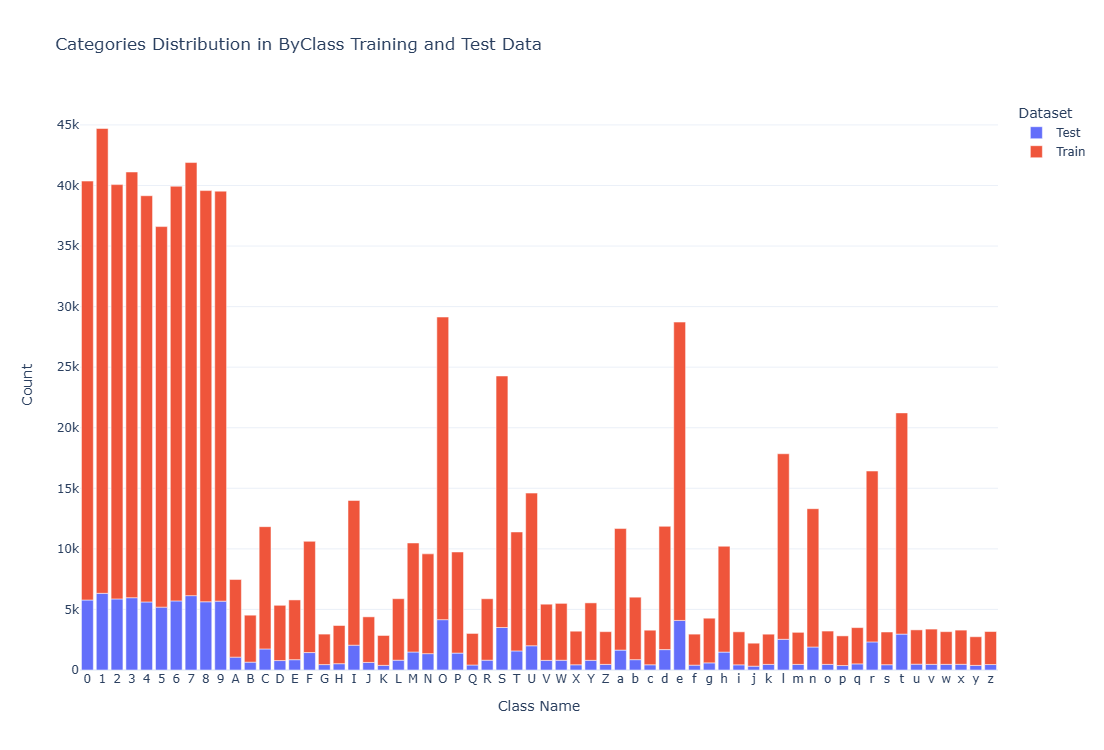

In [26]:
df_train = pd.DataFrame({'Class': emnist["ByClass"]["y_train"], 'Dataset': 'Train'})
df_test = pd.DataFrame({'Class': emnist["ByClass"]["y_test"], 'Dataset': 'Test'})

df_combined = pd.concat([df_train, df_test])
df_combined['Class Name'] = df_combined['Class'].map(bC_map)
class_counts = df_combined.groupby(['Class Name', 'Dataset']).size().reset_index(name='Count')

fig = px.bar(class_counts, x='Class Name', y='Count', color='Dataset',
             title='Categories Distribution in ByClass Training and Test Data',
             labels={'x': 'Class', 'y': 'Count'})
fig.show()

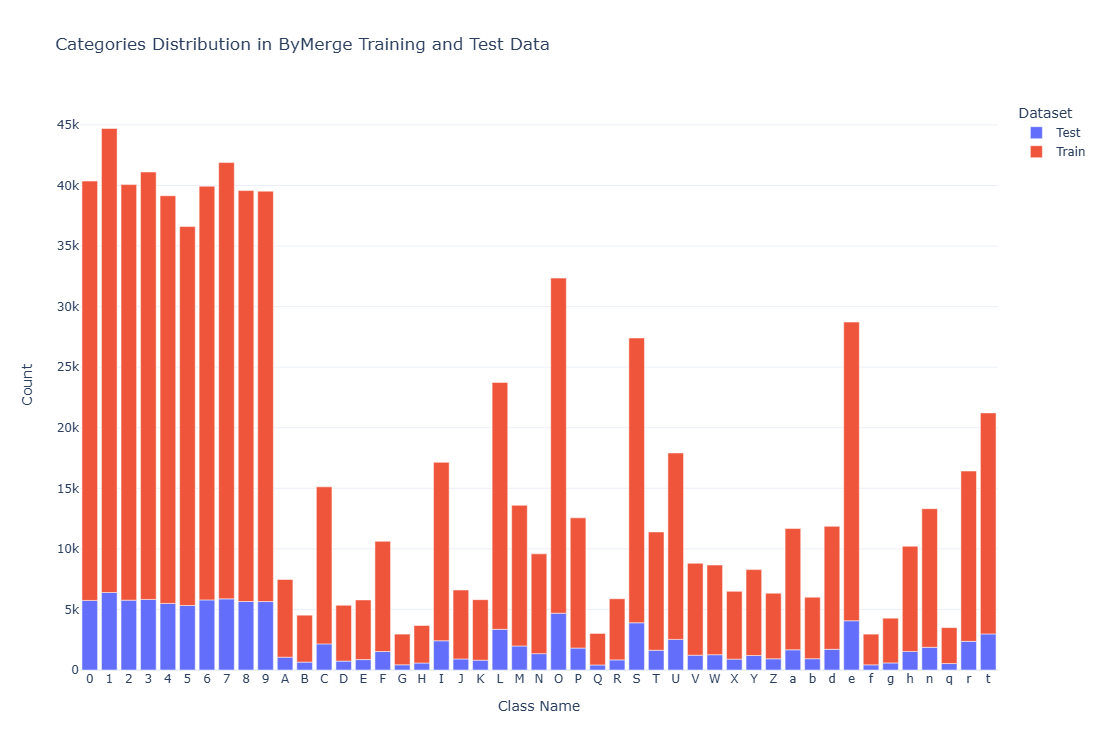

In [27]:
df_train = pd.DataFrame({'Class': emnist["ByMerge"]["y_train"], 'Dataset': 'Train'})
df_test = pd.DataFrame({'Class': emnist["ByMerge"]["y_test"], 'Dataset': 'Test'})

df_combined = pd.concat([df_train, df_test])
df_combined['Class Name'] = df_combined['Class'].map(bM_map)
class_counts = df_combined.groupby(['Class Name', 'Dataset']).size().reset_index(name='Count')

fig = px.bar(class_counts, x='Class Name', y='Count', color='Dataset',
             title='Categories Distribution in ByMerge Training and Test Data',
             labels={'x': 'Class', 'y': 'Count'})
fig.show()

---

# **Part II: Benchmarking**

---

# 2 Benchmarks

Now comes the second part of this notebook. ...
* What metrics to use?
* ...

#### Performance Metrics

* $Accuracy = \frac{Number\;of\;correct\;predictions}{Total\;number\;of\;predictions}$<br><br>

* $Precision = \frac{True\;Positives}{True\;Positives + False\;Positives}$<br><br>

* $Recall = \frac{True\;Positives}{True\;Positives + False\;Negatives}$<br><br>

* $F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$

<b>There is an important point we need to consider:</b><br>

The cross validation splitting strategy, including the split indices and how the data is shuffled, needs to be the same 
for all cross validation procedures, to have a fair comparison between the classifiers and for reproducability.
For this purpose we will use `StratifiedKFold` from scikit-learn and set the parameters accordingly. Since most of the classes in EMNIST are severely unbalanced, we decide on a stratified splitting strategy, to ensure the class distributions are retained in the training and testing subsets.

To ensure cross validation splits are the same for all following procedures, we will define a strategy (`cv`) that will be used throughout the rest of the notebook when needed. Additionally we create a list of common scikit evaluation metrics for classification (`scoring`), including the ones that we consider in our experiments.

In [28]:
# stratified k-fold to use in cross validation.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# a list containing strings of common evaluation metrics for classification.
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

We will define path variables which we will need to instruct our functions to store the results in the desired directory.

In [ ]:
# path variables for cross validation benchmark results of tree algorithms.
cv_trees_bc_path = os.path.join(os.getcwd() ,"benchmarks", "cv", "emnist-byclass", "trees")
cv_trees_bm_path = os.path.join(os.getcwd() ,"benchmarks", "cv", "emnist-bymerge", "trees")

# # path variables for cross validation benchmark results of trees and neighbors algorithms.
# bench_cv_trees = os.path.join("benchmarks", "cv", "emnist-byclass", "trees")
# bench_cv_neigh = os.path.join("benchmarks", "cv", "emnist-byclass", "neighbor")

# # path variables for testing benchmark results of trees and neighbors algorithms.
# bench_test_trees = os.path.join("benchmarks", "test", "emnist-byclass", "trees")
# bench_test_neigh = os.path.join("benchmarks", "test", "emnist-byclass", "neighbor")

# # here is an example. We need to join the desired path to our current working directory path.
# example_path = os.path.join(os.getcwd(), bench_cv_neigh)
# example_path

# 2. 1 Tree Classifiers

Let's begin by benchmarking various tree classifiers. The classifiers we will use are:
* Decision Tree
* Random Forest
* Adaboost Classifier with Decision Trees
* Gradient Boosting Classifier with ensembles of Decision Trees
  
For this section the features do not need to be scaled as tree algorithms are considering one feature at a time. 

We have implemented custom functions for cross validation and testing. Let's import these.

In [30]:
from src.utils.bench import cross_validate_classifiers
from src.utils.bench import evaluate_classifiers

Create a list of classifiers to use.

In [31]:
clf_list = [RandomForestClassifier(), 
            AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 4)), 
            GradientBoostingClassifier()]

Let's go and perform the cross validation procedure to set the benchmarks using the full emnist training dataset. Note that our custom function `cross_validate_classifiers` takes as argument a path, which is the path the cross validation results named by the used classifier will be stored in as csv files. The parameter `win_metric` must be an evaluation metric for the classification, which is used to determine the best classifier. Take a look at the docstring to see what this function exactly does and how the parameters should be chosen.

In [32]:
cross_validate_classifiers.__doc__

'Takes a list of scikit classifiers, performs cv for each and stores the results to the given path.\n    A dictionary with the best classifier from each split is returned but the storing process takes place for \n    all classifiers.'

# 2.1.1 Cross Validating Tree Classifiers

Trigger CV for $ByClass$ Dataset

In [ ]:
all_clf_bc, best_clf_bc = cross_validate_classifiers(clf_list,
                      emnist["ByClass"]["X_train"],
                      emnist["ByClass"]["y_train"],
                      cv=cv,
                      path=cv_trees_bc_path,
                      win_metric="accuracy",
                      average="macro")

Benchmarking Progress:   0%|          | 0/3 [00:00<?, ?it/s]


Building RandomForestClassifier


Trigger CV for $ByMerge$ Dataset

In [ ]:
all_clf_bm, best_clf_bm = cross_validate_classifiers(clf_list,
                      emnist["ByMerge"]["X_train"],
                      emnist["ByMerge"]["y_train"],
                      cv=cv,
                      path=cv_trees_bc_path,
                      win_metric="accuracy",
                      average="macro")

Since we now have a list of pretrained classifiers from the previous cross validation procedure we can evaluate the best classifiers using the test dataset. Again take a look at the docstring of our custom function `evaluate_classifiers` to be able to understand its functionality.

In [ ]:
evaluate_classifiers.__doc__

# 2.1.2 Testing best Tree Classifiers

In [ ]:
# path variables for cross validation benchmark results of tree algorithms.
test_trees_bc_path = os.path.join(os.getcwd() ,"benchmarks", "test", "emnist-byclass", "trees")
test_trees_bm_path = os.path.join(os.getcwd() ,"benchmarks", "test", "emnist-bymerge", "trees")

Trigger testing for $ByClass$ Dataset

In [ ]:
evaluate_classifiers(all_clf_bc,
                       X_test,
                       y_test,
                       path=test_trees_bc_path,
                       win_metric="accuracy",
                       average="macro")

Trigger test for $ByMerge$ Dataset

In [ ]:
evaluate_classifiers(all_clf_bm,
                       X_test,
                       y_test,
                       path=test_trees_bm_path,
                       win_metric="accuracy",
                       average="macro")

# 2.1.3 Conclusion

# 2. 2 K-Nearest Neighbor
Expalanation coming ...

In [ ]:
from root.processing.scalers import Standartizer

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# 2.2.1 Performing Gridsearch Cross Validation
We will determine the best number of neighbors in a grid search cross validation procedure for number of neighbors $n$ in {1, 3, 5, 7}

In [ ]:
kNN_param_grid={"n_neighbors": [1, 3, 5, 7]}

pipe_knn = Pipeline([
    ("Standartization", Standartizer(element_wise=True)),
    ("kNN_GSCV", GridSearchCV(
        estimator=KNeighborsClassifier(),
        scoring=scoring,
        param_grid=kNN_param_grid,
        cv=cv , n_jobs=-1, return_train_score=True, refit=scoring[0])
    )
])

pipe_knn.fit(X_train, y_train)

In [ ]:
clf = pipe_knn.named_steps["kNN_GSCV"].best_estimator_
knn_cv = pipe_knn.named_steps["kNN_GSCV"].cv_results_

estIdx = np.zeros(cv.n_splits)
estIdx[np.argmax(knn_cv["mean_test_accuracy"])] = 1
results = pd.DataFrame(knn_cv).join(pd.DataFrame(estIdx.astype(np.int8), columns=["best_estimator"]))

path = os.path.join(os.getcwd(), bench_test_neigh)
results.to_csv(os.path.join(path, f"{type(clf).__name__}.csv"), index=False)

display(results)

# 2.2.2 Testing best k-Nearest Neihbor Classifier

In [ ]:
clf = pipe_knn.named_steps["kNN_GSCV"].best_estimator_

all_clf, best_clf = cross_validate_classifiers([clf],
                      Standartizer(element_wise=True).fit_transform(X_train),
                      y_train,
                      cv=cv,
                      path=os.path.join(os.getcwd(), bench_cv_neigh),
                      win_metric="accuracy",
                      average="macro")

In [ ]:
evaluate_classifiers(all_clf,
                       Standartizer(element_wise=True).fit_transform(X_test),
                       y_test,
                       path=os.path.join(os.getcwd(), bench_cv_neigh),
                       win_metric="accuracy",
                       average="macro")

# 2. 3 Neural Networks
Explanation is coming ...

In [10]:
import tensorflow
from tensorflow import keras as keras

display(tensorflow.__version__, keras.__version__)

'2.16.1'

'3.3.3'

In [11]:
import tensorflow as tf

# Check if gpu is detected
tf.config.list_physical_devices("GPU")

[]

In [30]:
# Standartization of data required
X_train_ = Standartizer(element_wise=True).fit_transform(X_train)

In [31]:
def build_model(neurons_per_layer=[800, 350, 100, 50], learning_rate=3e-3, input_shape=[784,]):
    num_classes = len(np.unique(y_train))
    
    inputs = keras.Input(shape=input_shape)


    assert len(neurons_per_layer) == 4, 'Model requires exactly 4 hidden layers'
    x = keras.layers.Dense(units=neurons_per_layer[0], activation='relu')(inputs)
    x = keras.layers.Dense(units=neurons_per_layer[1], activation='relu')(x)
    x = keras.layers.Dense(units=neurons_per_layer[2], activation='relu')(x)
    x = keras.layers.Dense(units=neurons_per_layer[3], activation='relu')(x)

    outputs = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [37]:
model = keras.models.Sequential([
     keras.layers.InputLayer(input_shape=(784)),
     keras.layers.Dense(units=800, activation="relu"),
     keras.layers.Dense(units=350, activation="relu"),
     keras.layers.Dense(units=100, activation="relu"),
     keras.layers.Dense(units=52, activation="relu"),
     keras.layers.Dense(units=len(np.unique(y_train)), activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 800)               628000    
                                                                 
 dense_6 (Dense)             (None, 350)               280350    
                                                                 
 dense_7 (Dense)             (None, 100)               35100     
                                                                 
 dense_8 (Dense)             (None, 52)                5252      
                                                                 
 dense_9 (Dense)             (None, 10)                530       
                                                                 
Total params: 949,232
Trainable params: 949,232
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

In [39]:
with tf.device("/GPU:0"):
    model.fit(Standartizer(True).fit_transform(X_train),
              y_train,
              epochs=15,
              batch_size=24,
              validation_split=0.2,
              shuffle=True)

Epoch 1/15
1867/1867 [==============================] - 6s 3ms/step - loss: 0.3154 - accuracy: 0.9062 - val_loss: 0.1761 - val_accuracy: 0.9437
Epoch 2/15
1867/1867 [==============================] - 5s 3ms/step - loss: 0.1267 - accuracy: 0.9624 - val_loss: 0.1257 - val_accuracy: 0.9624
Epoch 3/15
1867/1867 [==============================] - 6s 3ms/step - loss: 0.0845 - accuracy: 0.9740 - val_loss: 0.1146 - val_accuracy: 0.9654
Epoch 4/15
1867/1867 [==============================] - 6s 3ms/step - loss: 0.0588 - accuracy: 0.9826 - val_loss: 0.0957 - val_accuracy: 0.9702
Epoch 5/15
1867/1867 [==============================] - 6s 3ms/step - loss: 0.0408 - accuracy: 0.9888 - val_loss: 0.0939 - val_accuracy: 0.9707
Epoch 6/15
1867/1867 [==============================] - 5s 3ms/step - loss: 0.0286 - accuracy: 0.9922 - val_loss: 0.0974 - val_accuracy: 0.9697
Epoch 7/15
1867/1867 [==============================] - 6s 3ms/step - loss: 0.0188 - accuracy: 0.9956 - val_loss: 0.0946 - val_accuracy:

<Axes: >

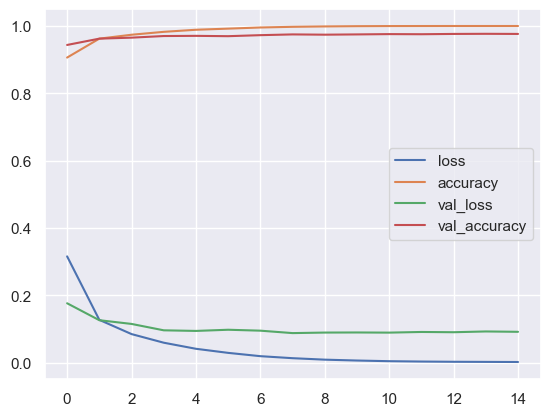

In [130]:
pd.DataFrame(model.history.history).plot(kind="line")

In [41]:
# from keras.wrappers.scikit_learn import KerasClassifier

# keras_clf = KerasClassifier(build_fn=build_model)

# keras_clf.fit(X_train_,
#               y_train,
#               epochs=5,
#               validation_split=0.2,
#               callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

In [42]:
# from scikeras.wrappers import KerasClassifier

# keras_clf = KerasClassifier(model=build_model,
#                             loss=keras.losses.sparse_categorical_crossentropy,
#                             batch_size=16)

# keras_clf.fit(X_train_,
#               y_train,
#               epochs=5,
#               validation_split=0.2,
#               callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

In [131]:
model.evaluate(X_test, y_test)

438/438 [==============================] - 1s 2ms/step - loss: 6.2984 - accuracy: 0.9739


[6.298382759094238, 0.9739285707473755]

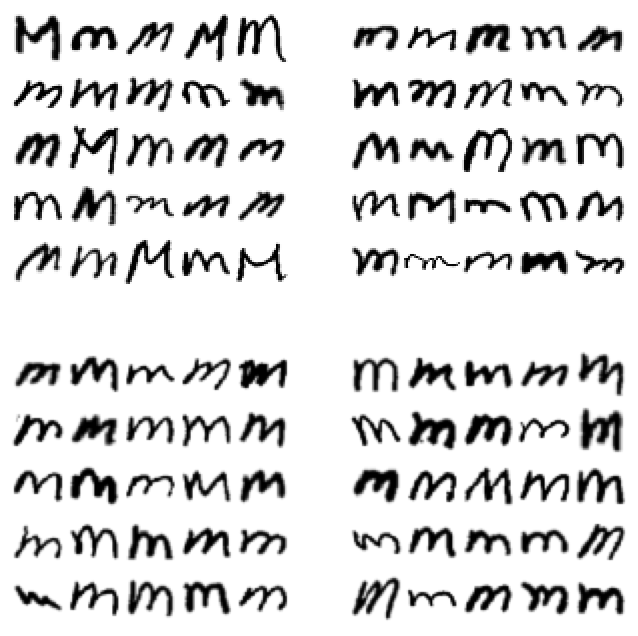

In [92]:
def plot_digits(instances, images_per_row=5):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images_per_col = (len(instances) - 1) // images_per_row + 1
    image_grid = np.zeros((images_per_col * size, images_per_row * size))

    for index, instance in enumerate(instances):
        row = index // images_per_row
        col = index % images_per_row
        image_grid[row * size : (row + 1) * size,
                   col * size : (col + 1) * size] = instance.reshape(size, size)
    
    plt.imshow(image_grid, cmap="binary")
    plt.axis("off")

cl_a, cl_b = "22", "48"
X_aa = X_test[(y_test.astype(str) == cl_a) & (y_pred.astype(str) == cl_a)]
X_ab = X_test[(y_test.astype(str) == cl_a) & (y_pred.astype(str) == cl_b)]
X_ba = X_test[(y_test.astype(str) == cl_b) & (y_pred.astype(str) == cl_a)]
X_bb = X_test[(y_test.astype(str) == cl_b) & (y_pred.astype(str) == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

#### Save prepared data

In [ ]:
# %time pd.DataFrame(X_train).to_csv('../Datasets/Prepared/EMNIST/Train/emnist-byclass-train-prepared.csv')
# pd.DataFrame(y_train).to_csv('../Datasets/Prepared/EMNIST/Train/emnist-byclass-train-labels.csv')

# %time pd.DataFrame(X_test).to_csv('../Datasets/Prepared/EMNIST/Test/emnist-byclass-test-prepared.csv')
# pd.DataFrame(y_test).to_csv('../Datasets/Prepared/EMNIST/Test/emnist-byclass-test-labels.csv')

In [ ]:
# df_X_train = pd.DataFrame(X_train)
# df_y_train = pd.DataFrame(y_train)
# df_X_test = pd.DataFrame(X_test)
# df_y_test = pd.DataFrame(y_test)

# df_X_train.columns = df_X_train.columns.astype(str)
# df_y_train.columns = df_y_train.columns.astype(str)
# df_X_test.columns = df_X_test.columns.astype(str)
# df_y_test.columns = df_y_test.columns.astype(str)

# %time df_X_train.to_parquet('../Datasets/Prepared/EMNIST/Train/emnist-byclass-train-prepared.gzip.parquet', compression='gzip')
# df_y_train.to_parquet('../Datasets/Prepared/EMNIST/Train/emnist-byclass-train-labels.gzip.parquet', compression='gzip')

# %time df_X_test.to_parquet('../Datasets/Prepared/EMNIST/Test/emnist-byclass-test-prepared.gzip.parquet', compression='gzip')
# df_y_test.to_parquet('../Datasets/Prepared/EMNIST/Test/emnist-byclass-test-labels.gzip.parquet', compression='gzip')

In [ ]:
# pd.DataFrame(index=classes_map.keys(),
#              data=classes_map.values()).to_csv('../Datasets/Prepared/EMNIST/emnist_classes_map.csv')

In [ ]:
# %time pd.DataFrame(X_train).to_parquet('../Datasets/Prepared/EMNIST/Train/emnist-byclass-train-prepared.gzip.parquet', compression='gzip')
# pd.DataFrame(y_train).to_parquet('../Datasets/Prepared/EMNIST/Train/emnist-byclass-train-labels.gzip.parquet', compression='gzip')

# %time pd.DataFrame(X_test).to_parquet('../Datasets/Prepared/EMNIST/Test/emnist-byclass-test-prepared.gzip.parquet', compression='gzip')
# pd.DataFrame(y_test).to_parquet('../Datasets/Prepared/EMNIST/Test/emnist-byclass-test-labels.gzip.parquet', compression='gzip')

# Bibliography

<a id='1'></a>
[1] G. Cohen, S. Afshar, J. Tapson, und A. van Schaik, EMNIST: an extension of MNIST to handwritten letters. 2017.

# Classification of Stars, Galaxies and Quasars. Sloan Digital Sky Survey DR17: SDSS17

In [73]:
from sklearn.cluster import KMeans

sample_size = 1000



KMeans()

X.shape

(70000, 784)

In [112]:
from collections import Counter


sample_size = 1000
class_distribution = y_train.value_counts().sort_index()
total_samples = sum(class_distribution)

proportions = [count / total_samples for count in class_distribution]
np.floor(proportions * class_distribution)

class
0    544.0
1    709.0
2    558.0
3    582.0
4    532.0
5    455.0
6    540.0
7    607.0
8    532.0
9    553.0
Name: count, dtype: float64

In [113]:
stratified_counts = [int(round(prop * sample_size)) for prop in proportions]
stratified_counts

[99, 113, 100, 102, 97, 90, 98, 104, 98, 99]

In [114]:
from SamplingMethods.SamplingMethods

class
0    5522
1    6302
2    5592
3    5713
4    5459
5    5050
6    5501
7    5834
8    5460
9    5567
Name: count, dtype: int64

In [132]:
y_map[22]

'M'

In [134]:
labels = pd.Series(y_pred).apply(lambda x: y_map[x])

In [108]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [136]:
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test,
                      y_pred,
                      normalize='pred', labels=list(y_map.values()))

<Axes: >

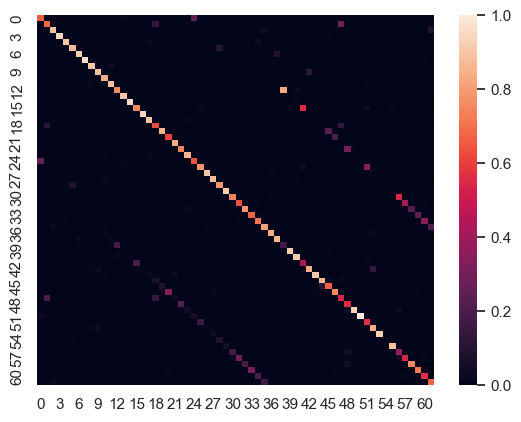

In [141]:
sns.heatmap(cm)

In [15]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

X,y = load_iris(return_X_y=True)
X = X[:, 2:]
X.shape, y.shape

((150, 2), (150,))

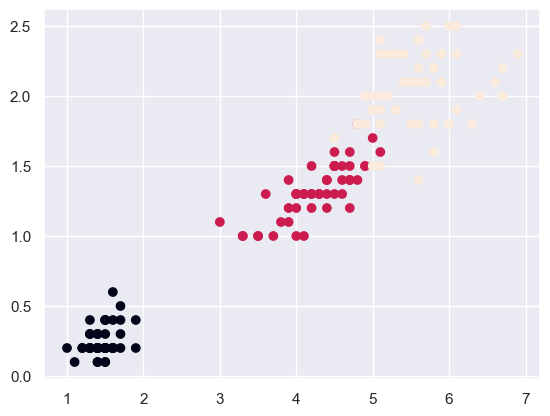

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
def ClusteringCentroidsSelection():
    pass

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(